<a href="https://colab.research.google.com/github/phylypo/TimeSeriesPrediction/blob/main/Time_Series_StateSpace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of Time Series Forecasting from Statistical to ML and Recent DL Approaches 

Topics for this notebook: 
- Structural Model
 - Local Linear
 - Smooth Trend
- HMM
- Deep space

## State Space Model (SSM)

SSMs model the temporal structure of the data via a latent state $l_t ∈ R^L$ that can be used to encode time series components such as level, trend, and seasonality patterns.



Known under several different names:
 - structural models (econometrics), 
 - dynamic linear models (statistics), 
 - Bayesian forecasting models (statistics), 
 - linear system models (engineering), 
 - Kalman filtering models (control engineering)

State space model (SSM) is based on a structural analysis of the problem that can be described by different components like trend, seasonality, cycle. These explanatory variable(s) are modeled separately then being put together in state space model.

"State space models provide a principled framework for modeling and learning time series patterns such as trend and seasonality. Prominent examples include ARIMA models
and exponential smoothing. SSMs are particularly well-suited for applications where the structure of the time series is well-understood, as they allow for the incorporation of structural assumptions into the model." (Rangapuram, NeurIPS 2018)

We will cover the follow algorithms:
1. ARIMA (see the intro notebook)
2. Structural Time Series Model (STSM) or Unobserved Components Model (UCM)
 - Local Linear Trend Model
 - Smooth Trend Model
3. HMM

Ref:
- "Deep State Space Models for Time Series Forecasting" Amazon Research", Rangapuram, et al., NeurIPS 2018. (https://papers.nips.cc/paper/8004-deep-state-space-models-for-time-series-forecasting.pdf)
- https://towardsdatascience.com/state-space-model-and-kalman-filter-for-time-series-prediction-basic-structural-dynamic-linear-2421d7b49fa6)


### Structural Model

Univariate unobserved components time series model

These are also known as structural time series models, and decompose a (univariate) time series into trend, seasonal, cyclical, and irregular components.

We will explore:
- local linear trend
- smooth trend

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html

In [ ]:
# code from: https://github.com/theJollySin/scipy_con_2019/blob/master/modern_time_series_analysis/ModernTimeSeriesAnalysis/StateSpaceModels/1_Structural_Time_Series_INSTRUCTOR.ipynb

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 6]
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels

import scipy
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


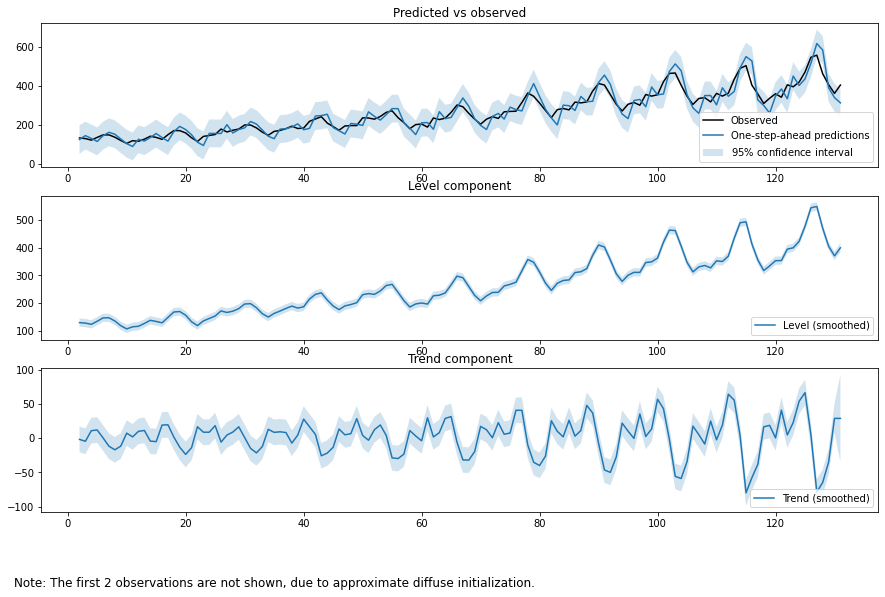

In [ ]:
train =  df[0:-12]

# smooth trend model without seasonal or cyclical components
model = {
    'level': 'smooth trend', 'cycle': False, 'seasonal': None, 
}
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html
gcag_mod = sm.tsa.UnobservedComponents(train['AirPassengers'], **model)
gcag_res = gcag_mod.fit()

fig = gcag_res.plot_components(legend_loc='lower right', figsize=(15, 9));



In [ ]:
# Perform rolling prediction and multistep forecast
num_steps = 12
predict_res = gcag_res.get_prediction(dynamic=train['AirPassengers'].shape[0] - num_steps)

predict = predict_res.predicted_mean
ci = predict_res.conf_int()
predict_res

55.55154893888224

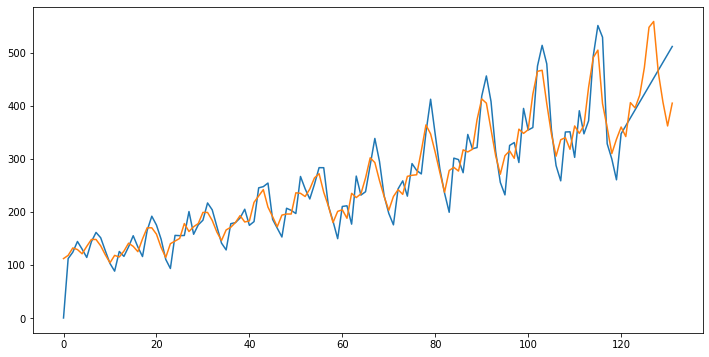

In [ ]:
matplotlib.rcParams['figure.figsize'] = [12, 6]
plt.plot(predict)
plt.plot(train['AirPassengers'])
maxidx=train['AirPassengers'].shape[0]
mae = abs(df['AirPassengers'][maxidx-12:maxidx].values - predict[maxidx-12:maxidx]).mean()
mae

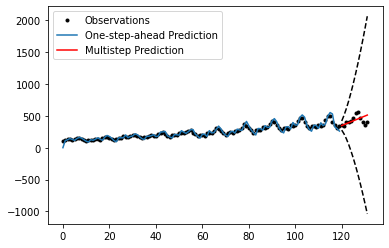

In [ ]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train['AirPassengers'], 'k.', label='Observations');
ax.plot(train.index[:-num_steps], predict[:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');
legend = ax.legend(loc='upper left');

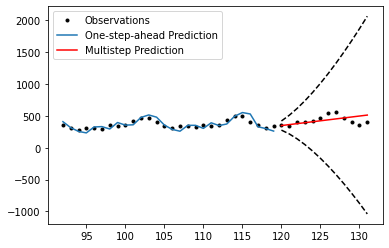

In [ ]:

fig, ax = plt.subplots()
# Plot the results
ax.plot(train.index[-40:], train['AirPassengers'][-40:], 'k.', label='Observations');
ax.plot(train.index[-40:-num_steps], predict[-40:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');
legend = ax.legend(loc='upper left');

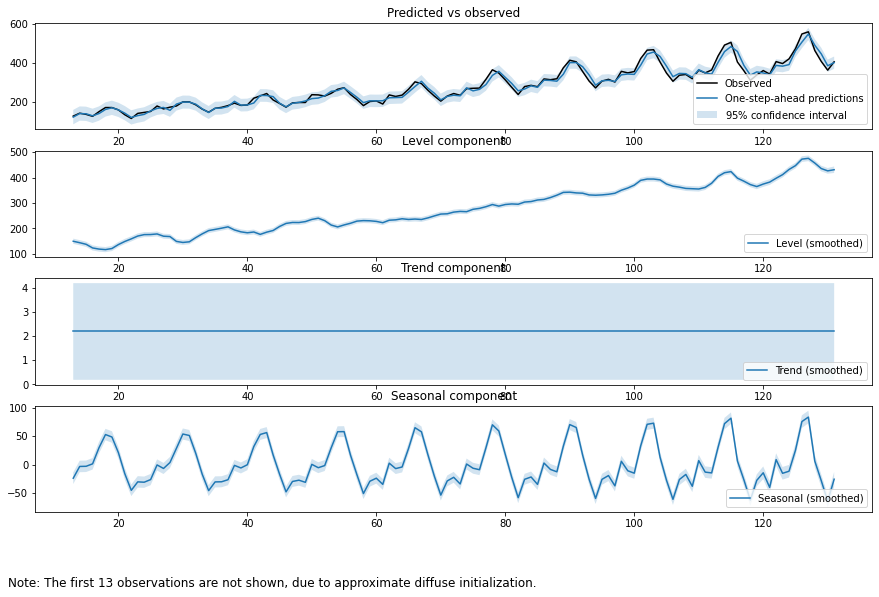

In [ ]:
# Add seasonal
seasonal_model = {
    'level': 'local linear trend',
    'seasonal': 12
}
mod = sm.tsa.UnobservedComponents(train['AirPassengers'], **seasonal_model)
res = mod.fit(method='powell', disp=False)

fig = res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [ ]:
num_steps = 12
predict_res = res.get_prediction(dynamic=train['AirPassengers'].shape[0] - num_steps)

predict = predict_res.predicted_mean
ci = predict_res.conf_int()

52.859554289152506

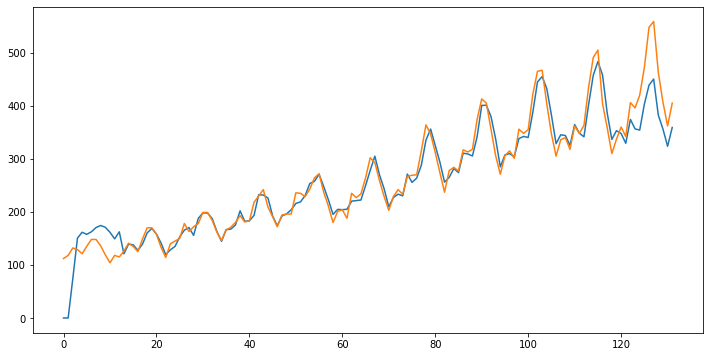

In [ ]:
matplotlib.rcParams['figure.figsize'] = [12, 6]
plt.plot(predict)
plt.plot(train['AirPassengers'])
#startidx=131
mae = abs(df['AirPassengers'][131-12:131].values - predict[131-12:131]).mean()
mae

### Hidden Markov Model

- State space - underlining state can't be observed but you can observe the output
- strutural: state and measure quantity are the same thing with error
- state space: give some kind of intuation and model of the underlying dynamic 
- Just need to know state at t-1, no other previous states


**HMM**

Show  evidence of the underlying dynamic or extraordinary state change

Does not apply here?
- where is the state transition matrix? prev price-> curr price (need to bucket it?)
- After modeling, the model can sample data-- predict
- Regime changes - can give better understanding to the data.

Parameter Estimation: Baum-Welch algorithm
- how to determine parameter
- use it when just knowing the states and nothing else 
- get maximum likelihood and update parameters - run several loops -- local max
- $\theta = (A, B, \pi)$ 
A:transistion matrix, B:matrix of lieklihood of x given y, $\pi$:prior
- forward step: the probability of seeing the observations $y_{1},y_{2},\ldots ,y_{t}$ and being in state t
- backward: the probability of the ending partial sequence $y_{t+1},\ldots ,y_{T}$ given starting state  i at time  t

Smoothing/state labeling:  Viterbi algorithm



In [ ]:
!pip install hmmlearn

     |████████████████████████████████| 368kB 5.3MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hmmlearn

from hmmlearn.hmm import GaussianHMM

In [ ]:
#https://github.com/theJollySin/scipy_con_2019/blob/master/modern_time_series_analysis/ModernTimeSeriesAnalysis/StateSpaceModels/2_Gaussian_HMM_INSTRUCTOR.ipynb
def fitHMM(vals, n_states):
    vals = np.reshape(vals,[len(vals),1])
    
    # fit Gaussian HMM to Q
    model = GaussianHMM(n_components=n_states, n_iter=100).fit(vals)
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(vals)
 
    # fit HMM parameters
    mus = np.squeeze(model.means_)
    sigmas = np.squeeze(np.sqrt(model.covars_))
    transmat = np.array(model.transmat_)
    print(mus)
    print(sigmas)
    # re-order parameters in ascending order of mean of underlying distribution
    idx      = np.argsort(mus)
    mus      = mus[idx]
    sigmas   = sigmas[idx]
    transmat = transmat[idx, :][:, idx]
    
    state_dict = {}
    states = [i for i in range(n_states)]
    for i in idx:
        state_dict[i] = states[idx[i]]
    
    relabeled_states = [state_dict[h] for h in hidden_states]
    return (relabeled_states, mus, sigmas, transmat, model)

In [ ]:
train = data[0:100]
test = data[100:120]
hidden_states, mus, sigmas, transmat, model = fitHMM(train, 4)


[237.5500853  183.52304868 314.29513515 134.30838131]
[17.83905309 15.39107255 42.44486021 17.08013322]


In [ ]:
def plot_states(ts_vals, states, time_vals):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('AirPassenger',         color=color)
    ax1.plot(time_vals, ts_vals,      color=color)
    ax1.tick_params(axis='y',            labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Hidden state', color=color)  
    ax2.plot(time_vals,states,     color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()

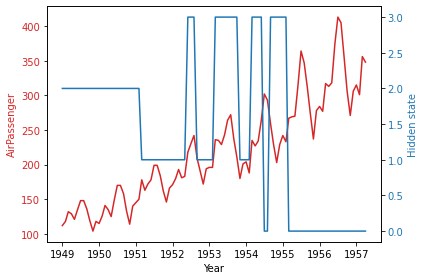

In [ ]:
plot_states(train, hidden_states, train.index)

In [ ]:
# can use sample to predict????
res = np.squeeze(model.sample(1000)[0])
plt.plot(res, label='Predict ARMA')
plt.legend(loc='best')
plt.show()

### Deep State Space Models
There are a few model related to state space approach inclding DSSM and DMM that won't cover here. See below links for detail.
- Deep State Space Models (DSSM) for Time Series Forecasting", Syama Rangapuram, Matthias Seeger, et. al., NeurIps 2018. (https://papers.nips.cc/paper/8004-deep-state-space-models-for-time-series-forecasting.pdf
- Deep Markov Model (DMM) -- Rahul G Krishnan, Uri Shalit, and David Sontag. Deep kalman filters. arXiv preprint
arXiv:1511.05121, 2015


## Summary

In the State Space model for time series, the approach give the interpretability with trend and seasonality. We see a few different approaches in structural model. Then in Hidden Markov Model, we can learn about the hidden states.

